In [1]:
import glob
import os
import sys

sys.path.insert(0, "hbb_interaction_network")

import pickle as pkl
import time
from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch_geometric
from sklearn.metrics import auc, roc_curve
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataListLoader, DataLoader

import awkward as ak
import fastjet
import vector

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

from tqdm.notebook import tqdm

In [2]:
# define the global base device
world_size = torch.cuda.device_count()
multi_gpu = world_size >= 2
if world_size:
    device = torch.device("cuda:0")
    for i in range(world_size):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    device = "cpu"
    print("Device: CPU")

Device 0: NVIDIA A10


In [3]:
# ! pip install torch_geometric fastjet

In [3]:
! ls toptagging/*/processed

toptagging/test/processed:
data_0.pt  data_1.pt  data_2.pt  data_3.pt  data_quick.pt

toptagging/train/processed:
data_0.pt   data_11.pt	data_2.pt  data_4.pt  data_6.pt  data_8.pt
data_10.pt  data_1.pt	data_3.pt  data_5.pt  data_7.pt  data_9.pt

toptagging/val/processed:
data_0.pt  data_1.pt  data_2.pt  data_3.pt


In [4]:
# load the datafiles
def load_data(dataset_path, flag, n_files=-1):
    data_files = glob.glob(f"{dataset_path}/{flag}/processed/*")
        
    data = []
    for i, file in enumerate(data_files):
        data += torch.load(f"{dataset_path}/{flag}/processed/data_{i}.pt")
        print(f"--- loaded file {i} from `{flag}` directory")
        if n_files!=-1 and i==n_files-1:
            break
                
    return data

dataset_path = "toptagging/"

data_train = load_data(dataset_path, "train", n_files=2)
# data_valid = load_data(dataset_path, "val", n_files=4)
data_test = load_data(dataset_path, "val", n_files=1)

--- loaded file 0 from `train` directory
--- loaded file 1 from `train` directory
--- loaded file 0 from `val` directory


In [5]:
len(data_train)

200001

In [23]:
data_train[:4]

[Data(x=[23, 7], y=0),
 Data(x=[43, 7], y=0),
 Data(x=[41, 7], y=0),
 Data(x=[25, 7], y=0)]

In [6]:
"""
The 7 input features per particle in the jet.
    1. ∆η difference in pseudorapidity between the particle and the jet axis
    2. ∆φ difference in azimuthal angle between the particle and the jet axis
    3. log pT logarithm of the particle’s pT
    4. log E logarithm of the particle’s energy
    5. log pT/pT_jet logarithm of the particle’s pT relative to the jet pT
    6. log E/E_jet logarithm of the particle’s energy relative to the jet energy
    7. ∆R
"""

feature_dict = {
    "eta": 0,
    "phi": 1,
    "pt": 2,
    "E": 3,
    "pt/jet_pt": 4,
    "E/jet_E": 5,
    "deltaR": 6,    
}

feature_label = {
    "eta": r"Particle $\left| \eta \right|$",
    "phi": r"Particle $\left| \phi \right|$",
    "pt": r"Particle $p_T$",
    "E": "Particle E",
    "pt/jet_pt": r"Log($\frac{p_T(particle)}{p_T(jet)})$",
    "E/jet_E": r"$Log(\frac{E(particle)}{E(jet)})$",
    "deltaR": r"$\Delta R(particle, jet)$", 
    
}

In [7]:
num_features = 7

In [8]:
batch_size = 100

train_loader = DataLoader(data_train, batch_size)
# valid_loader = DataLoader(data_valid, batch_size)
test_loader = DataLoader(data_test, batch_size)

In [25]:
for i, bb in enumerate(train_loader):
#     x, y = batch.x, batch.y
#     print(x.shape, y.shape)
#     if i==5:
        break
bb

DataBatch(x=[4643, 7], y=[100], batch=[4643], ptr=[101])

In [26]:
bb

DataBatch(x=[4643, 7], y=[100], batch=[4643], ptr=[101])

In [118]:
bb.x

tensor([[ 4.8051e-03, -1.2196e-02,  5.8162e+00,  ..., -6.0878e-01,
         -6.0632e-01,  1.3108e-02],
        [-3.0414e-02,  1.1893e-01,  4.3164e+00,  ..., -2.1086e+00,
         -2.1307e+00,  1.2275e-01],
        [ 3.2171e-03, -7.5693e-03,  4.3124e+00,  ..., -2.1126e+00,
         -2.1113e+00,  8.2246e-03],
        ...,
        [-9.3287e-02,  3.7845e-01, -1.0176e+00,  ..., -7.3324e+00,
         -7.4193e+00,  3.8978e-01],
        [-5.6471e-01,  4.0648e-01, -1.1138e+00,  ..., -7.4286e+00,
         -7.9230e+00,  6.9579e-01],
        [ 5.0191e-01, -2.3996e-02, -1.8225e+00,  ..., -8.1372e+00,
         -7.6588e+00,  5.0248e-01]])

In [14]:
mask bb.x[:,2] > 0

tensor([ 5.8162,  4.3164,  4.3124,  ..., -1.0176, -1.1138, -1.8225])

In [31]:
np.ptp(bb.x[:,1], axis=-1, keepdims=True)

tensor([1.5909])

In [38]:
bb.x.shape[0]

4643

In [9]:
def translate_jets(batch, width=1.0, device='cpu'):
    width = 1.0
    batch = batch.to("cpu")
    X = batch.x.numpy()
    mask = (X[:,2] > 0).reshape(X.shape[0],1)
    ptp_eta = np.ptp(X[:,1], axis=-1, keepdims=True)
    ptp_phi = np.ptp(X[:,0], axis=-1, keepdims=True)
    low_eta  = -width*ptp_eta
    high_eta = +width*ptp_eta
    low_phi = np.maximum(-width*ptp_phi, -np.pi-np.min(X[:,2]).reshape(ptp_phi.shape))
    high_phi = np.minimum(+width*ptp_phi, +np.pi-np.max(X[:,2]).reshape(ptp_phi.shape))
    shift_eta = mask*np.random.uniform(low=low_eta, high=high_eta, size=(X.shape[0], 1))
    shift_phi = mask*np.random.uniform(low=low_phi, high=high_phi, size=(X.shape[0], 1))
    shift = np.hstack((shift_eta, shift_phi, np.zeros((X.shape[0], 5))))
    X = X + shift
    X = torch.tensor(X).to(device)
    batch.x = X.float()
    return batch.to(device)

In [10]:
def rotate_jets(batch, device):
    batch = batch.to("cpu")
    rot_angle = np.random.rand(len(batch))*2*np.pi
    c = np.cos(rot_angle)
    s = np.sin(rot_angle)
    o = np.ones_like(rot_angle)
    z = np.zeros_like(rot_angle)
    rot_matrix = np.array([[o, z, z], [z, c, -s], [z, s, c]])
    rot_matrix = rot_matrix.transpose(2,0,1)

    x_rot = np.zeros_like(batch.x.cpu())
    for i in range(len(batch)):
#         indices = torch.where(batch.batch==i)[0]
        x_ = batch[i].x[:,:3]
        batch[i].x[:,:3] = torch.tensor(np.einsum('ij,lj->il', x_, rot_matrix[i]))
#         x_rot[indices[0].item():indices[-1].item()+1,:3] = np.einsum('ij,lj->il', x_, rot_matrix[i])
#     x_rot = torch.tensor(x_rot)
#     x_rot[:,3:] = batch.x[:,3:]
#     batch.x = x_rot
    return batch.to(device)

In [11]:
def rescale_pts(batch):
    x_rscl = batch.x.clone()
    batch.x[:,2] = torch.nan_to_num(x_rscl[:,2]/600, posinf=0.0, neginf=0.0)
    return batch

In [12]:
def normalize_pts( batch ):
    x_norm = batch.x.clone()
    batch.x[:,2] = torch.nan_to_num(x_norm[:,2]/torch.sum(x_norm[:,2]), posinf = 0.0, neginf = 0.0 )
    return batch

In [13]:
# 0,1,2, eta, phi, pT

In [14]:
from typing import Callable, Union

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch_cluster import knn_graph
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.conv import MessagePassing, EdgeConv
from torch_geometric.typing import Adj, PairTensor
from pdb import set_trace as bp

class EdgeConvBlock(nn.Module):
    def __init__(self, in_size, layer_size, depth):
        super(EdgeConvBlock, self).__init__()

        layers = []

        layers.append(nn.Linear(in_size * 2, layer_size))
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

        for i in range(depth):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())

        self.edge_conv = EdgeConv(nn.Sequential(*layers), aggr="mean")

    def forward(self, x, edge_index):
        return self.edge_conv(x, edge_index)


class ParticleNet(nn.Module):
    def __init__(
        self,
        node_feat_size,
        num_classes=1,
        k=16,
        depth=2,
        dropout=False,
        device = "cpu"
    ):
        super(ParticleNet, self).__init__()

        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.k = k
        self.num_edge_conv_blocks = 3
        
        self.augmentations = True

        self.kernel_sizes = [self.node_feat_size, 64, 128, 256]
        self.input_sizes = np.cumsum(self.kernel_sizes)  # [4, 4+64, 4+64+128, 4+64+128+256]

        self.fc_size = 256
        self.device = device

        if dropout:
            self.dropout = 0.1
            self.dropout_layer = nn.Dropout(p=self.dropout)
        else:
            self.dropout = None

        # define the edgeconvblocks
        self.edge_conv_blocks = nn.ModuleList()
        for i in range(0, self.num_edge_conv_blocks):
            self.edge_conv_blocks.append(EdgeConvBlock(self.input_sizes[i], self.kernel_sizes[i + 1], depth=depth))

        # define the fully connected networks (post-edgeconvs)
        self.fc1 = nn.Linear(self.input_sizes[-1], self.fc_size)
        self.fc2 = nn.Linear(self.fc_size, self.num_classes)

        self.sig = nn.Sigmoid()
    
#     def augmentations(self, batch):
#         batch = rescale_pts(batch)
#         batch = rotate_jets(batch, self.device)
#         batch = translate_jets(batch, device = self.device)
#         batch = normalize_pts(batch)
    

    def forward(self, batch):
        if self.augmentations:
            batch = rescale_pts(batch)
            batch = rotate_jets(batch, self.device)
            batch = translate_jets(batch, device = self.device)
            batch = normalize_pts(batch)
        
        x = batch.x
        y = batch.y
        batch = batch.batch

        # input transformations
#         x[:, 2] = (x[:, 2] - 1.7) * 0.7  # part_pt_log
#         x[:, 3] = (x[:, 3] - 2.0) * 0.7  # part_e_log
#         x[:, 4] = (x[:, 4] + 4.7) * 0.7  # part_logptrel
#         x[:, 5] = (x[:, 5] + 4.7) * 0.7  # part_logerel
#         x[:, 6] = (x[:, 6] - 0.2) * 4.7  # part_deltaR

        edge_index = {}
        for i in range(self.num_edge_conv_blocks):
            # using only angular coords for knn in first edgeconv block
            edge_index[f"edge_conv_{i}"] = knn_graph(x[:, :2], self.k, batch) if i == 0 else knn_graph(x, self.k, batch)

            out = self.edge_conv_blocks[i](x, edge_index[f"edge_conv_{i}"])

            x = torch.cat((out, x), dim=1)  # concatenating with latent features i.e. skip connections per EdgeConvBlock

        x = global_mean_pool(x, batch)

        x = F.relu(self.fc1(x))
        if self.dropout:
            x = self.dropout_layer(x)
        x = self.fc2(x)
        x = self.sig(x)

        return x, y

In [15]:
# setup the input/output dimension of the model
num_features = 7  # we have 7 input features
num_classes = 1  # we have one output node

In [16]:
model_kwargs = {
    "node_feat_size": num_features,
    "num_classes": num_classes,
    "k": 16,
    "depth": 3,
    "dropout": True,
    "device":device
}

model = ParticleNet(**model_kwargs)
model.to(device)

ParticleNet(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (edge_conv_blocks): ModuleList(
    (0): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=14, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Linear(in_features=64, out_features=64, bias=True)
        (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Linear(in_features=64, out_features=64, bias=True)
        (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): ReLU()
      ))
    )
    (1): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=142, out_feat

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.BCELoss()
sig = nn.Sigmoid()

model.train()

ParticleNet(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (edge_conv_blocks): ModuleList(
    (0): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=14, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Linear(in_features=64, out_features=64, bias=True)
        (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Linear(in_features=64, out_features=64, bias=True)
        (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): ReLU()
      ))
    )
    (1): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=142, out_feat

In [18]:
# quick training without monitoring validation
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.BCELoss()
sig = nn.Sigmoid()

model.train()

for epoch in tqdm(range(10)):
    losses = []
    for i, batch in tqdm(enumerate(train_loader)):
        preds, targets = model(batch.to(device))
        loss = criterion(sig(preds), targets.reshape(-1, 1).float())
#         print(f"batch # {i}, loss={loss:.3f}")

        for param in model.parameters():
            param.grad = None
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())

    losses = sum(losses)/len(losses)
    print(f"epoch {epoch}, loss: {losses}")

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

epoch 0, loss: 0.573233962059021


0it [00:00, ?it/s]

epoch 1, loss: 0.5649367570877075


0it [00:00, ?it/s]

epoch 2, loss: 0.5618266463279724


0it [00:00, ?it/s]

epoch 3, loss: 0.5604450106620789


0it [00:00, ?it/s]

epoch 4, loss: 0.5591593980789185


0it [00:00, ?it/s]

epoch 5, loss: 0.5580376386642456


0it [00:00, ?it/s]

epoch 6, loss: 0.5573257803916931


0it [00:00, ?it/s]

epoch 7, loss: 0.5568434596061707


0it [00:00, ?it/s]

epoch 8, loss: 0.5564178228378296


0it [00:00, ?it/s]

epoch 9, loss: 0.5559555292129517


In [19]:
# model.eval()
# with torch.no_grad():
#     for i, batch in tqdm(enumerate(val_loader)):
#         preds, targets = model(batch.to(device))
#         loss = criterion(sig(preds), targets.reshape(-1, 1).float())
#         val_losses.append(loss.item())
        
# val_loss = sum(val_losses) / len(val_losses)
# print("Val loss : {}".format(val_loss))

In [20]:
def make_roc(y_test, y_score, save_path = 'roc', save_flag=False):
    fpr, tpr, _ = roc_curve(y_test, y_score)

    fig, ax = plt.subplots(figsize=(8,7))
    ax.plot(
        tpr,
        fpr,
        color="darkorange",
        lw=2,
        label=f"AUC = {round(auc(fpr, tpr)*100,2)}%",
    )
    plt.xlim([0.0, 1.0])
    plt.ylabel("False Positive Rate")
    plt.xlabel("True Positive Rate")
    plt.yscale("log")
    plt.legend(loc="lower right")
    if save_flag:
        plt.savefig(f'toptagging_expts/plots/{save_path}.jpg')
    

In [21]:
print("- making predictions")
y_score = None
y_test = None

model.eval()
model.augmentations = False
for i, batch in tqdm(enumerate(test_loader)):

    preds, targets = model(batch.to(device))
    preds = preds.detach().cpu()

    if y_score is None:
        y_score = preds[:].detach().cpu().reshape(-1)
        y_test = targets.detach().cpu()
    else:
        y_score = torch.cat([y_score, preds[:].detach().cpu().reshape(-1)])
        y_test = torch.cat([y_test, targets.detach().cpu()])

#     if i==100:
#         break

- making predictions


0it [00:00, ?it/s]

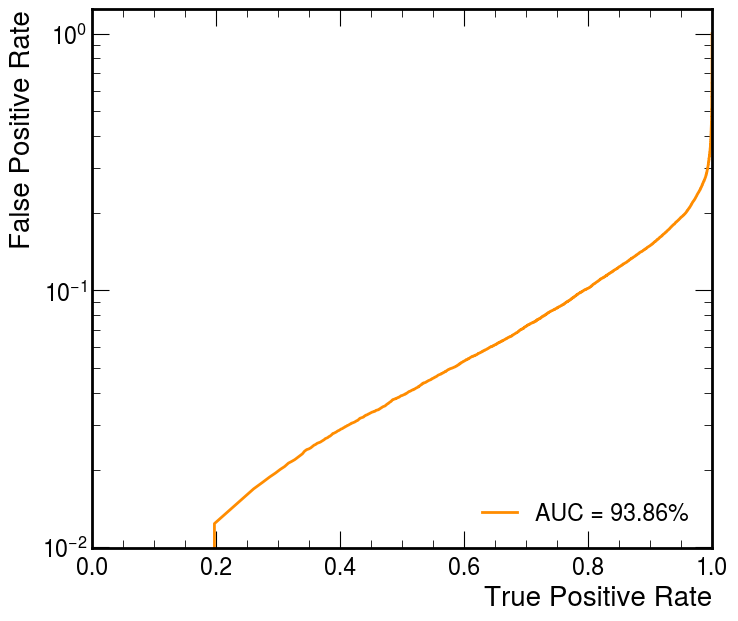

In [22]:
plt.rcParams.update({"font.size": 20})
make_roc(y_test, y_score, 'roc_rescl_rotate_transl_norm',save_flag=False)